<a href="https://colab.research.google.com/github/kashishnarwal/Week-2/blob/main/Week_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

raw_path = "/content/sustainable_ag_starter.csv"
data = pd.read_csv(raw_path)

In [ ]:
numeric_features = ["Area_ha","Rainfall_mm","Fertilizer_kg_ha",
                    "Tmin_C","Tmax_C","SOC_pct","Year"]
categorical_features = ["State","District","Season","Crop"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Outlier handling
def iqr_clip(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor*iqr
    upper = q3 + factor*iqr
    return series.clip(lower, upper)

clean = data.copy()
for col in ["Area_ha","Production_t","Yield_t_ha"]:
    clean[col] = iqr_clip(clean[col])

# Feature engineering

clean["GDD"] = ((clean["Tmax_C"] + clean["Tmin_C"]) / 2 - 10).clip(lower=0) * 120/10
clean["Rainfall_Anom"] = clean["Rainfall_mm"] - clean["Rainfall_mm"].median()

target = "Yield_t_ha"
feature_cols = numeric_features + ["GDD","Rainfall_Anom"] + categorical_features

X = clean[feature_cols]
y = clean[target]

# Modeling
model = RandomForestRegressor(n_estimators=300, random_state=42)
pipe = Pipeline(steps=[("preprocessor", preprocessor),
                      ("model", model)])

mask = y.notna()
X_train, X_test, y_train, y_test = train_test_split(
    X[mask], y[mask], test_size=0.2, random_state=42
)

cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="r2")
pipe.fit(X_train, y_train)
r2_test = pipe.score(X_test, y_test)

print("Cross-val R² mean:", cv_scores.mean())
print("Test R²:", r2_test)

clean_path = "cleaned_ag_data.csv"
pipe_path = "preprocessing_pipeline.pkl"

clean.to_csv(clean_path, index=False)
with open(pipe_path, "wb") as f:
    pickle.dump(pipe, f)

print("Cleaned data saved at:", clean_path)
print("Pipeline saved at:", pipe_path)


Cross-val R² mean: 0.9587479123023247
Test R²: 0.9461489686358847
Cleaned data saved at: cleaned_ag_data.csv
Pipeline saved at: preprocessing_pipeline.pkl


   Year           State    District  Season       Crop   Area_ha  Rainfall_mm  \
0  2002   Uttar Pradesh  District_1    Rabi  Groundnut  685.1925        834.3   
1  2018  Madhya Pradesh  District_2    Rabi     Pulses  155.5300        618.4   
2  2015     West Bengal  District_3    Rabi      Maize   47.2900        716.0   
3  2010      Tamil Nadu  District_4    Rabi    Mustard   84.7600       1154.2   
4  2010          Punjab  District_5  Kharif  Groundnut  574.2000          NaN   

   Fertilizer_kg_ha  Tmin_C  Tmax_C  SOC_pct  Production_t  Yield_t_ha    GDD  \
0             212.5    24.7    29.1     0.72    1915.07125    2.211442  202.8   
1             189.1    15.6    36.5     1.20     143.82000    0.924709  192.6   
2             102.6    24.2    29.1     1.06     124.21000    2.626560  199.8   
3             176.8    16.5    35.2     0.39     100.09000    1.180864  190.2   
4             180.7    16.6    30.7     1.14     991.30000    1.726402  163.8   

   Rainfall_Anom  
0      

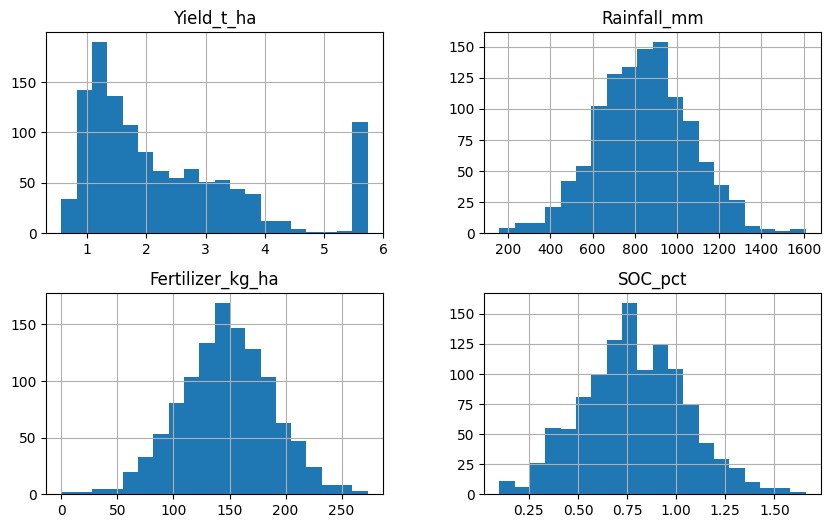

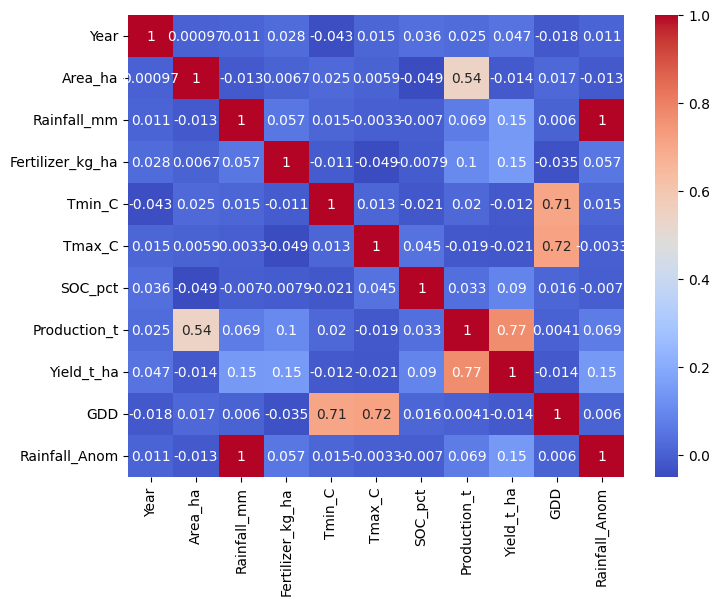


Model Comparison:
                Model  R2 Score      RMSE
0  Linear Regression  0.941400  0.327973
1      Random Forest  0.946240  0.314136
2  Gradient Boosting  0.949769  0.303650


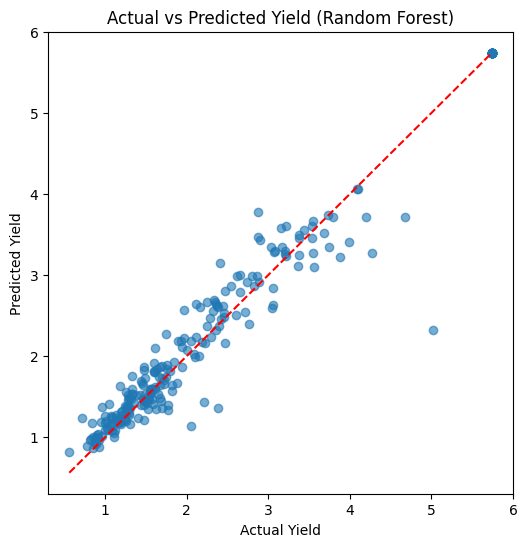

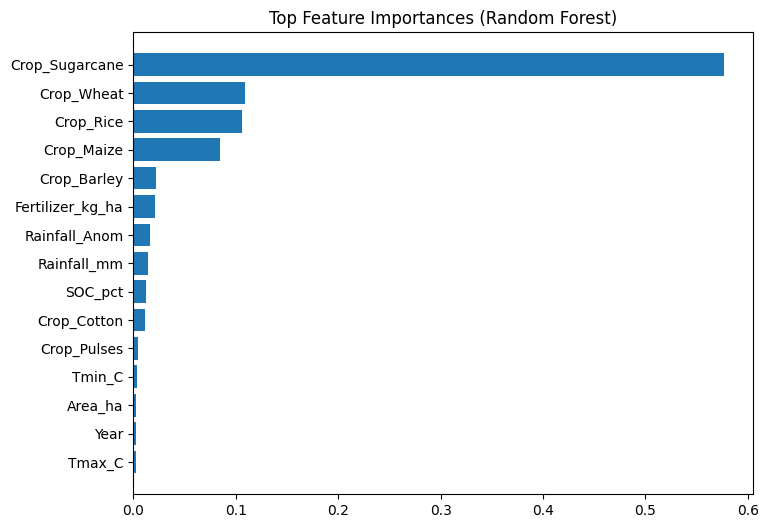


Final Random Forest model saved as final_rf_model.pkl

Sample Input:
       Area_ha  Rainfall_mm  Fertilizer_kg_ha  Tmin_C  Tmax_C  SOC_pct  Year  \
1178    342.1        622.6             117.5    23.1    27.4     0.53  2006   

        GDD  Rainfall_Anom        State     District  Season   Crop  
1178  183.0        -223.35  West Bengal  District_19  Kharif  Maize  

Predicted Yield: [2.17861694]


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans

from math import sqrt
import pickle

data = pd.read_csv("/content/cleaned_ag_data.csv")


print(data.head())
print(data.info())
print(data.describe())


print("\nMissing values:\n", data.isnull().sum())

data[["Yield_t_ha","Rainfall_mm","Fertilizer_kg_ha","SOC_pct"]].hist(bins=20, figsize=(10,6))
plt.show()


plt.figure(figsize=(8,6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()

def iqr_clip(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor*iqr
    upper = q3 + factor*iqr
    return series.clip(lower, upper)

clean = data.copy()
for col in ["Area_ha","Production_t","Yield_t_ha"]:
    clean[col] = iqr_clip(clean[col])


clean["GDD"] = ((clean["Tmax_C"] + clean["Tmin_C"])/2 - 10).clip(lower=0) * 120/10
clean["Rainfall_Anom"] = clean["Rainfall_mm"] - clean["Rainfall_mm"].median()

target = "Yield_t_ha"
numeric_features = ["Area_ha","Rainfall_mm","Fertilizer_kg_ha","Tmin_C","Tmax_C","SOC_pct","Year","GDD","Rainfall_Anom"]
categorical_features = ["State","District","Season","Crop"]

X = clean[numeric_features + categorical_features]
y = clean[target]

mask = y.notna()
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = []
trained_models = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    results.append([name, r2, rmse])
    trained_models[name] = pipe

results_df = pd.DataFrame(results, columns=["Model","R2 Score","RMSE"])
print("\nModel Comparison:\n", results_df)


best_model = trained_models["Random Forest"]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Yield (Random Forest)")
plt.show()

# Feature Importance (Random Forest only)
rf_model = trained_models["Random Forest"].named_steps["model"]
ohe = trained_models["Random Forest"].named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]

# Get feature names
cat_features = ohe.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_features)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[-15:]  # top 15

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.title("Top Feature Importances (Random Forest)")
plt.show()

with open("final_rf_model.pkl", "wb") as f:
    pickle.dump(trained_models["Random Forest"], f)

print("\nFinal Random Forest model saved as final_rf_model.pkl")

# Example prediction on one row
sample = X_test.iloc[[0]]
print("\nSample Input:\n", sample)
print("\nPredicted Yield:", best_model.predict(sample))
